
# Deep Learning Course

 <img src="http://usblogs.pwc.com/emerging-technology/wp-content/uploads/2017/07/deep-learning-900x280.png" >


# Deep Learning - Stacking Model Test

Developed by [Sergio Castelblanco](http://www.linkedin.com/in/sergio-castelblanco/) - [Jesús Solano](mailto:ja.solano588@uniandes.edu.co)


version 2.0, July  2018

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
import livelossplot
%matplotlib inline

Using TensorFlow backend.


In [0]:
# If datasets already exist do nothing. 


if not os.path.exists('dataTesting.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTesting.csv
    
if not os.path.exists('dataTraining.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTraining.csv
    

if not os.path.exists('images_resize_gray.zip'):
  # Install the PyDrive wrapper & import libraries.
  # This only needs to be done once per notebook.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download a file based on its file ID(Grey).
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  file_id = '1ZzSvFeCsLVW4hPWqyf6jW0rAvyQt1L7J'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(downloaded['title'])
  !unzip -q images_resize_gray.zip 

  # Download a file based on its file ID(Color).
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  # id 160x256 95 : 1ZO1wPtxWfnthbm2NrXt4ca1ZvuxQWD_r
  #file_id = '1hAOuBMKUJDiyaHz6fVkwwSAHkmEVNvmP'
  
  #file_id = '1ZO1wPtxWfnthbm2NrXt4ca1ZvuxQWD_r'
  #downloaded = drive.CreateFile({'id': file_id})
  #downloaded.GetContentFile(downloaded['title'])
  #!unzip -q images_resize_color.zip 

dataTraining = pd.read_csv("dataTraining.csv",index_col=0)
dataTesting = pd.read_csv("dataTesting.csv",index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Read Images

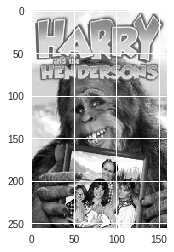

In [5]:
# Show an image example - Gray .
image = io.imread(os.path.join('images_resize_gray', str(dataTraining.index[124]) + '_resize_gray.jpeg'))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

In [6]:

from skimage.transform import resize
print('\nLoading images for testing...')
images_testing = []
for i in dataTesting.index:
    img= io.imread(os.path.join('images_resize_gray', str(i) + '_resize_gray.jpeg'))
    img = resize(img, (80, 128), mode='reflect')
    img = [img] * 3
    images_testing.append(img)

testingImagesGray = np.asarray(images_testing)



Loading images for testing...


In [0]:

testingImagesGray = np.rollaxis(testingImagesGray, 1, 4)


## Images Preprocessing - VGG

In [0]:
from keras.applications import VGG16
from skimage.transform import resize

vgg16 = VGG16(include_top=False, weights='imagenet')

testingImagesVGG = vgg16.predict(testingImagesGray)

## Text Preproccesing - Word2Vec 

In [0]:
# Load functions and prerrequisites of word2vec.
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np


hub_model = "https://tfhub.dev/google/Wiki-words-250/1"


def create_text_embedding(hub_model, input_sentences):
        
    SEQ_LENGTH = max(map(len, input_sentences))
    EMBEDDING_DIM = 250

    with tf.Graph().as_default() as g:

        embed_layer = hub.Module(hub_model,
        trainable=False, name='text_embedding')

        sentences = tf.placeholder(dtype=tf.string, shape=(None, SEQ_LENGTH))
        batch_size = tf.shape(sentences)[0]

        flat_sentences = tf.reshape(sentences, [-1])

        embeddings = embed_layer(flat_sentences)

        sentence_embedding = tf.reshape(embeddings, 
                                      [batch_size, SEQ_LENGTH, EMBEDDING_DIM])

        with tf.Session(graph=g) as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())

            output = sess.run(sentence_embedding, feed_dict={
                sentences: input_sentences
            })
            
    return output

In [0]:
# Get plots and lables for each plot.

xPlotTest = dataTesting['plot']


In [12]:
# Converts a text to a sequence of words (or tokens)

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences


maxWords = 200


xTokenTest = [text_to_word_sequence(x) for x in xPlotTest.tolist()]
xTokenTest = pad_sequences(xTokenTest, dtype='str', value=0, maxlen=maxWords)

xTokenTest.shape

(3383, 200)

In [13]:
# Apply Word2Vec to test.

xEmbeddingTest = create_text_embedding(hub_model, xTokenTest)

xEmbeddingTest.shape


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable text_embedding/embeddings/part_0:0,text_embedding/embeddings/part_1:0 from checkpoint b'/tmp/tfhub_modules/1e7e72950396d90315d3d9c57eddf5da44d4dca2/variables/variables' with embeddings


(3383, 200, 250)

## Stacking Model

In [0]:
from keras.models import load_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.models import model_from_config, Sequential

if not os.path.exists('imaNNtrainedGrayVGG.h5'):
  ! wget "https://github.com/castellwhite/MoviesClassification/raw/master/nnTrained/imaNNtrainedGrayVGG.h5"
  
if not os.path.exists('txtWord2Vec2.h5'):
  ! wget "https://github.com/castellwhite/MoviesClassification/raw/master/nnTrained/txtWord2Vec2.h5"

if not os.path.exists('mixNNtrained_Stack.h5'):
  ! wget "https://github.com/castellwhite/MoviesClassification/raw/master/nnTrained/mixNNtrained_Stack.h5"

In [0]:
# Load pretrained models.

from keras.models import load_model

Model_Ima= load_model('imaNNtrainedGrayVGG.h5')
Model_Text= load_model('txtWord2Vec2.h5')

Model_Mix = load_model('mixNNtrained_Stack.h5')

In [0]:
# Load predictions of trained models. 

predIma = Model_Ima.predict(testingImagesVGG)
predText =Model_Text.predict(xEmbeddingTest)



In [0]:
import numpy as np

stackTest =  np.c_[predIma,predText]

predIma = Model_Mix.predict(stackTest)

In [0]:
# Print prediction for test (kaggle) data. 

yPredTest = Model_Mix.predict(stackTest)

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(yPredTest, index=dataTesting.index, columns=cols).to_csv('pred_genres_stack_VGG_word2vec_1.csv', index_label='ID')


In [0]:
from google.colab import files

files.download('pred_genres_stack_VGG_word2vec_1.csv')

In [0]:
!pip3 install tqdm
!pip3 install livelossplot